In [ ]:
#!/bin/bash
!kaggle datasets download mathchi/diabetes-data-set

Dataset URL: https://www.kaggle.com/datasets/mathchi/diabetes-data-set
License(s): CC0-1.0
  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 9.37MB/s]


In [ ]:
!unzip diabetes-data-set

Archive:  diabetes-data-set.zip
  inflating: diabetes.csv            


In [ ]:
!pip install lazypredict
import lazypredict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from sklearn.preprocessing import Normalizer
from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
from matplotlib import rcParams
import shap

# **Data Exploration**#

Detailed analysis and visualization of the dataset to uncover insights.

In [ ]:
df = pd.read_csv('/content/diabetes.csv')

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.60,0.63,50,1
1,1,85,66,29,0,26.60,0.35,31,0
2,8,183,64,0,0,23.30,0.67,32,1
3,1,89,66,23,94,28.10,0.17,21,0
4,0,137,40,35,168,43.10,2.29,33,1


In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


In [ ]:
df.isna().sum().sum()

0

In [ ]:
df.duplicated().sum()

0

In [ ]:
feature_names=df.columns

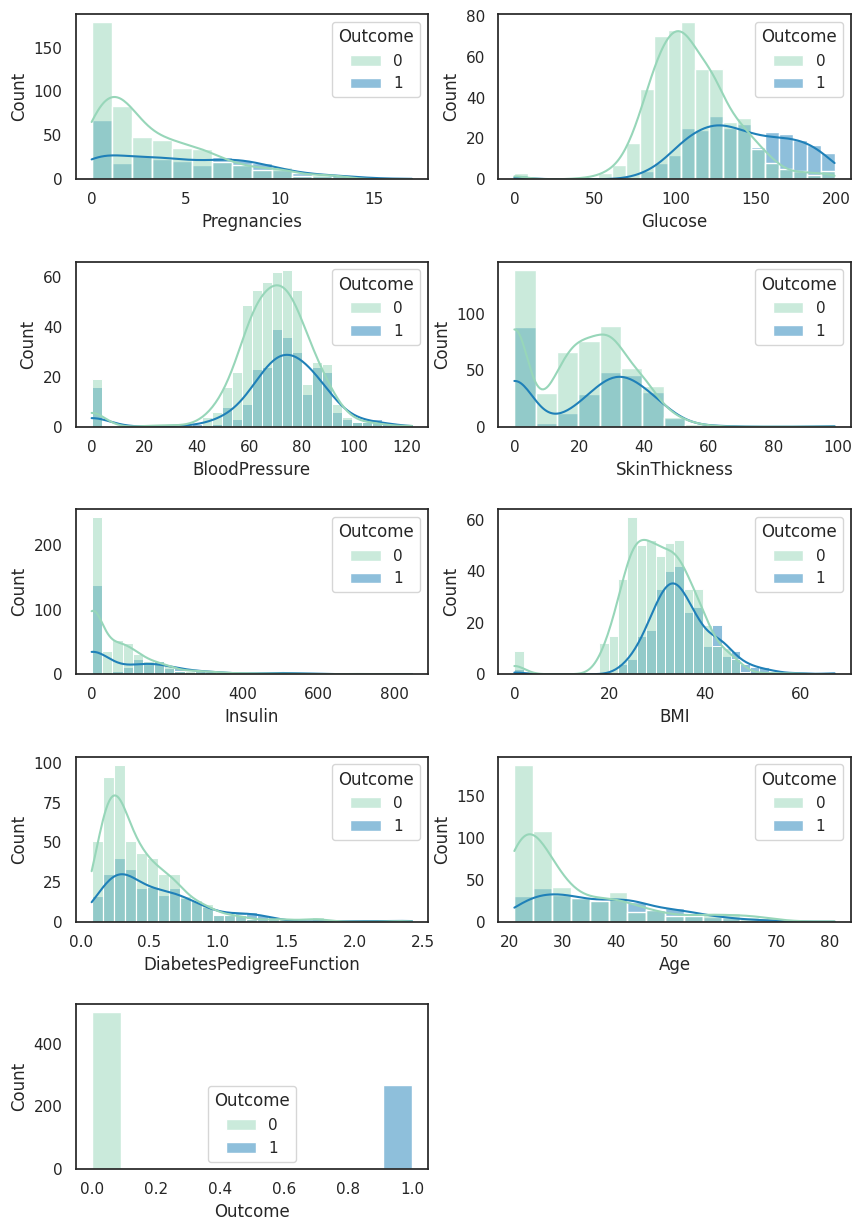

In [ ]:
rcParams['figure.figsize'] = 10,15
sns.set(font_scale = 1)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

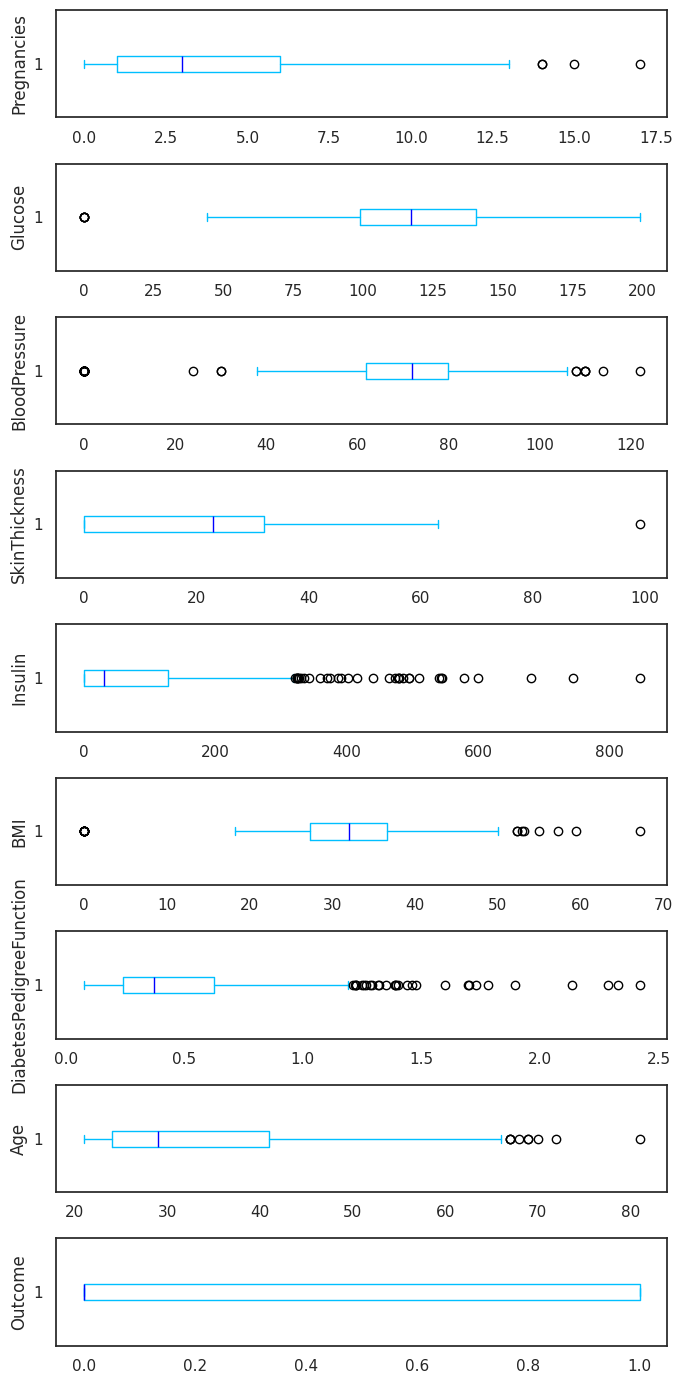

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(9, 1, figsize=(7, 14))
i = 0
for col in df.columns:
    axs[i].boxplot(df[col], vert=False, boxprops=dict(color='deepskyblue'),
                   whiskerprops=dict(color='deepskyblue'),
                   capprops=dict(color='deepskyblue'),
                   medianprops=dict(color='blue'))
    axs[i].set_ylabel(col)
    i += 1
plt.tight_layout()
plt.show()


# **Removing Outliers**

In [ ]:
# Identify the quartiles
q1, q3 = np.percentile(df['Insulin'], [25, 75])
# Calculate the interquartile range
iqr = q3 - q1
# Calculate the lower and upper bounds
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
# Drop the outliers
clean_data = df[(df['Insulin'] >= lower_bound)
				& (df['Insulin'] <= upper_bound)]


# Identify the quartiles
q1, q3 = np.percentile(clean_data['Pregnancies'], [25, 75])
# Calculate the interquartile range
iqr = q3 - q1
# Calculate the lower and upper bounds
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
# Drop the outliers
clean_data = clean_data[(clean_data['Pregnancies'] >= lower_bound)
						& (clean_data['Pregnancies'] <= upper_bound)]


# Identify the quartiles
q1, q3 = np.percentile(clean_data['Age'], [25, 75])
# Calculate the interquartile range
iqr = q3 - q1
# Calculate the lower and upper bounds
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
# Drop the outliers
clean_data = clean_data[(clean_data['Age'] >= lower_bound)
						& (clean_data['Age'] <= upper_bound)]


# Identify the quartiles
q1, q3 = np.percentile(clean_data['Glucose'], [25, 75])
# Calculate the interquartile range
iqr = q3 - q1
# Calculate the lower and upper bounds
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
# Drop the outliers
clean_data = clean_data[(clean_data['Glucose'] >= lower_bound)
						& (clean_data['Glucose'] <= upper_bound)]


# Identify the quartiles
q1, q3 = np.percentile(clean_data['BloodPressure'], [25, 75])
# Calculate the interquartile range
iqr = q3 - q1
# Calculate the lower and upper bounds
lower_bound = q1 - (0.75 * iqr)
upper_bound = q3 + (0.75 * iqr)
# Drop the outliers
clean_data = clean_data[(clean_data['BloodPressure'] >= lower_bound)
						& (clean_data['BloodPressure'] <= upper_bound)]


# Identify the quartiles
q1, q3 = np.percentile(clean_data['BMI'], [25, 75])
# Calculate the interquartile range
iqr = q3 - q1
# Calculate the lower and upper bounds
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
# Drop the outliers
clean_data = clean_data[(clean_data['BMI'] >= lower_bound)
						& (clean_data['BMI'] <= upper_bound)]


# Identify the quartiles
q1, q3 = np.percentile(clean_data['DiabetesPedigreeFunction'], [25, 75])
# Calculate the interquartile range
iqr = q3 - q1
# Calculate the lower and upper bounds
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

# Drop the outliers
clean_data = clean_data[(clean_data['DiabetesPedigreeFunction'] >= lower_bound)
						& (clean_data['DiabetesPedigreeFunction'] <= upper_bound)]


# **Correlation Features**

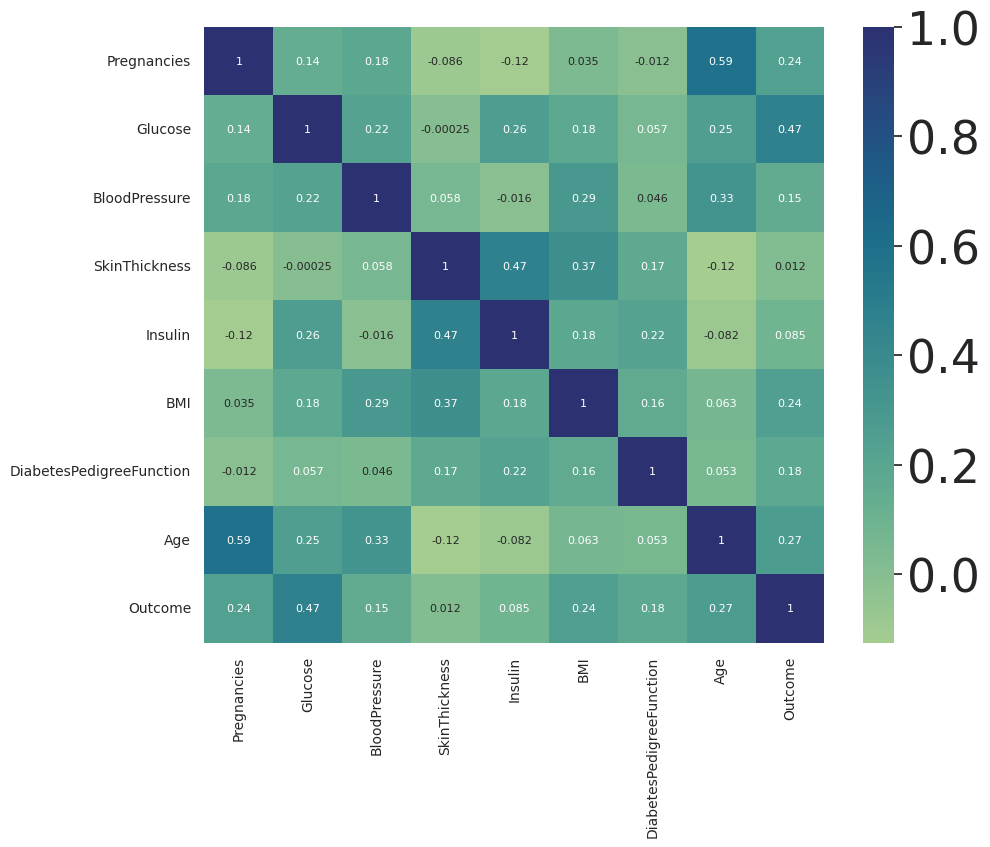

In [ ]:
corr = clean_data.corr()
plt.figure(figsize=(10, 8))

sns.heatmap(corr, annot=True, cmap="crest", annot_kws={"size": 8})
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

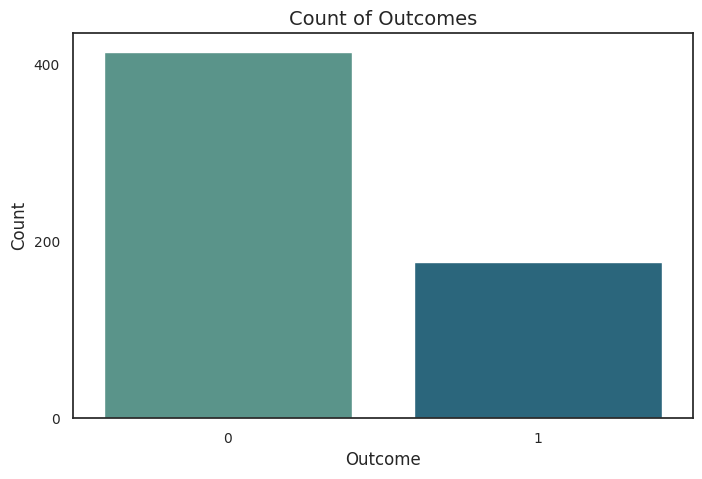

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x="Outcome", data=clean_data, palette="crest")
plt.title("Count of Outcomes", fontsize=14)
plt.xlabel("Outcome", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# **Prepare Data and Target**

In [ ]:
x = clean_data.drop(columns=['Outcome'])
y = clean_data['Outcome']

# **SMOTE Upsampling**

In [ ]:
smote = SMOTE(random_state=42)
X, Y = smote.fit_resample(x, y)

In [ ]:
Y.value_counts()

,count
Outcome,
1,415
0,415


# **Lazy Classifier**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(x_train, x_test, y_train, y_test)
models

 97%|█████████▋| 31/32 [00:07<00:00,  2.15it/s]

[LightGBM] [Info] Number of positive: 333, number of negative: 331
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 664, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501506 -> initscore=0.006024
[LightGBM] [Info] Start training from score 0.006024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

100%|██████████| 32/32 [00:07<00:00,  4.32it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.86,0.86,0.86,0.86,0.42
LGBMClassifier,0.84,0.84,0.84,0.84,0.31
RandomForestClassifier,0.84,0.84,0.84,0.84,0.76
LabelSpreading,0.83,0.83,0.83,0.83,0.17
LabelPropagation,0.83,0.83,0.83,0.83,0.10
BaggingClassifier,0.83,0.82,0.82,0.83,0.13
NuSVC,0.80,0.79,0.79,0.79,0.08
SVC,0.80,0.79,0.79,0.79,0.13
KNeighborsClassifier,0.79,0.79,0.79,0.79,0.08


# **ExtraTreesClassifier**


In [ ]:
model = ExtraTreesClassifier()
model.fit(x_train,y_train)

ExtraTreesClassifier()

In [ ]:
pred = model.predict(x_test)
accuracy = accuracy_score(y_test,pred)
recall = recall_score(y_test,pred)
print("Accuracy: ",accuracy)
print("Recall: ",recall)

Accuracy:  0.8433734939759037
Recall:  0.8536585365853658


In [ ]:
prediction = model.predict([[6,148,72,35,0,33.6,0.627,50]])

In [ ]:
dic = {0:'Non-Diabetic',1:'Diabetic'}

In [ ]:
dic[prediction[0]]

'Diabetic'

#  **SHAP**
Showing how the ExtraTreesClassifier works

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(x_test)

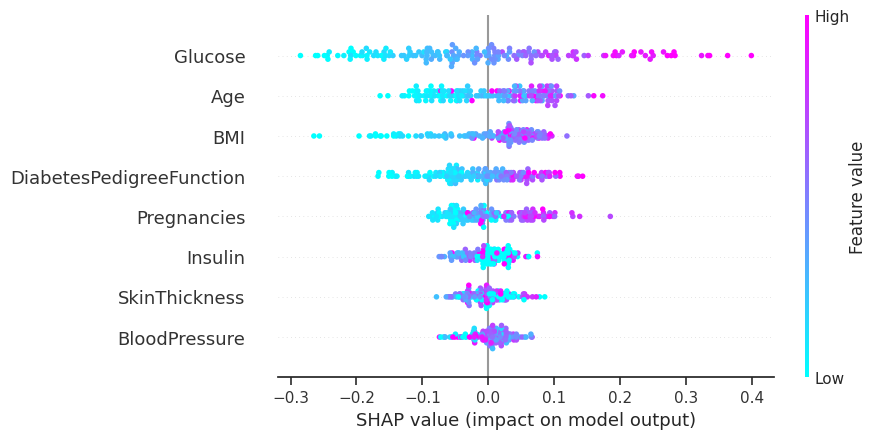

In [ ]:
shap.plots.beeswarm(shap_values[:,:,1], color=plt.get_cmap("cool"))

In [ ]:
import pickle
pickle.dump(model,open('model.pkl','wb'))